# Dataset Acquisition

In [1]:
# Download dataset from kaggle
!kaggle competitions download -c quora-question-pairs

quora-question-pairs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
# Extract downloaded zipfile
import zipfile

zipRef = zipfile.ZipFile("./quora-question-pairs.zip", "r")
zipRef.extractall("./Data/")
zipRef.close()

In [3]:
# Extract each zipfiles

file_list = ["train.csv.zip", "test.csv.zip", "sample_submission.csv.zip"]

for file in file_list:
    zipRef = zipfile.ZipFile("./Data/{}".format(file), "r")
    zipRef.extractall("./Data/")
    zipRef.close()

# Primary EDA

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [5]:
train_data = pd.read_csv("./Data/train.csv")

print(train_data.shape)
train_data.head()

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
print("File Size: ")
for file in os.listdir("./Data/"):
    if "csv" in file and "zip" not in file:
        print(file.ljust(30) + str(round(os.path.getsize("./Data/{}".format(file))/1000000, 2)) + " MB")

File Size: 
test.csv                      477.59 MB
train.csv                     63.4 MB
sample_submission.csv         22.35 MB


- Test dataset is larger than train dataset.
- This is to prevent direct searching of duplicated questions.

In [7]:
train_data.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [8]:
# Split 10% of data for validation

val_data = train_data[["question1", "question2", "is_duplicate"]].sample(frac = 0.1, random_state=1)
train_data = train_data.drop(val_data.index)[["question1", "question2", "is_duplicate"]]

In [9]:
print(train_data.shape)
print(val_data.shape)

(363861, 3)
(40429, 3)


### Duplicated questions

Let's first check how many questions are duplicated.

In [10]:
# Integrate the questions

train_set = pd.Series(train_data.question1.tolist() + train_data.question2.tolist()).astype(str)
print(train_set.shape)
train_set.head()

(727722,)


0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

In [11]:
print("Number of total unique questions: {}".format(len(train_set.unique())))
print("Number of duplicated questions: {}".format(train_set.duplicated().sum()))
print("Number of unique duplicated questions: {}".format(np.sum(train_set.value_counts() > 1)))

Number of total unique questions: 494012
Number of duplicated questions: 233710
Number of unique duplicated questions: 98915


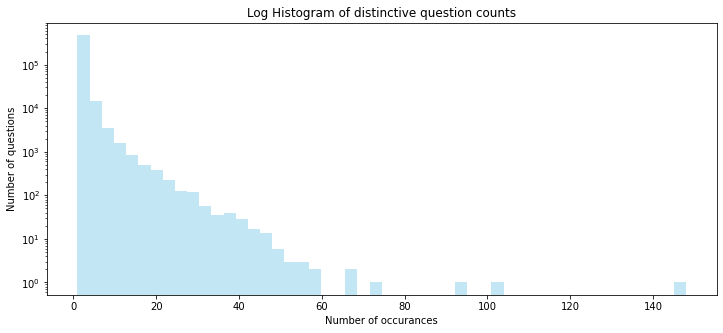

In [12]:
# Visualization (Histogram of number of unique questions)

plt.figure(figsize=(12,5))

train_set.value_counts().plot(kind="hist", bins=50, alpha=0.5, color="skyblue", label="questions")
plt.yscale("log", nonposy="clip")
plt.title("Log Histogram of distinctive question counts")
plt.xlabel("Number of occurances")
plt.ylabel("Number of questions")

plt.show()

- Most of the questions appear only once, which means they are not duplicated. 
- Questions that are duplicated have at most around 50 occurances. The remainder would be extreme outliers.

In [13]:
train_set.value_counts().describe()

count    494012.000000
mean          1.473086
std           1.785811
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         148.000000
dtype: float64

- As previously defined, most of the questions are unique.

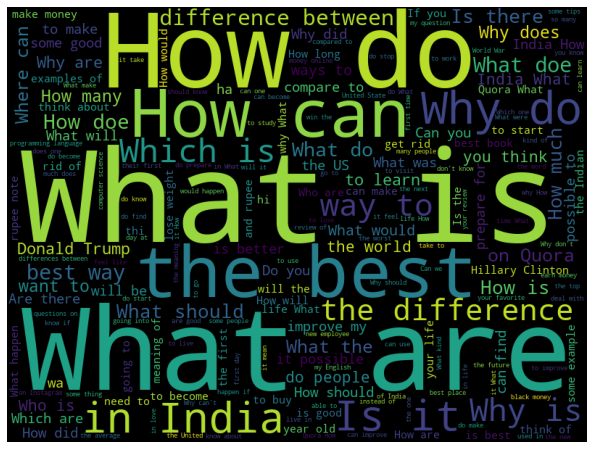

In [14]:
# Word frequency by wordclous

from wordcloud import WordCloud

cloud = WordCloud(width=800, height=600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize=(12,8))
plt.imshow(cloud)
plt.axis("off")
plt.show()

### Label Frequency

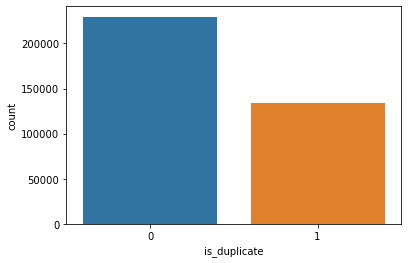

In [15]:
sns.countplot(train_data.is_duplicate)
plt.show()

In [16]:
print("Number of label 0: {}".format(train_data.is_duplicate.value_counts()[0]))
print("Number of label 1: {}".format(train_data.is_duplicate.value_counts()[1]))

Number of label 0: 229434
Number of label 1: 134427


- The labels are unevenly distributed. Since unbalance in the label can lead to biased analysis, we would have to undersample data from label 0.

### Word Counts

In [17]:
train_word_counts = train_set.apply(lambda x: len(x.split()))
train_word_counts

0         14
1          8
2         14
3         11
4         13
          ..
727717     8
727718    13
727719     9
727720     3
727721    25
Length: 727722, dtype: int64

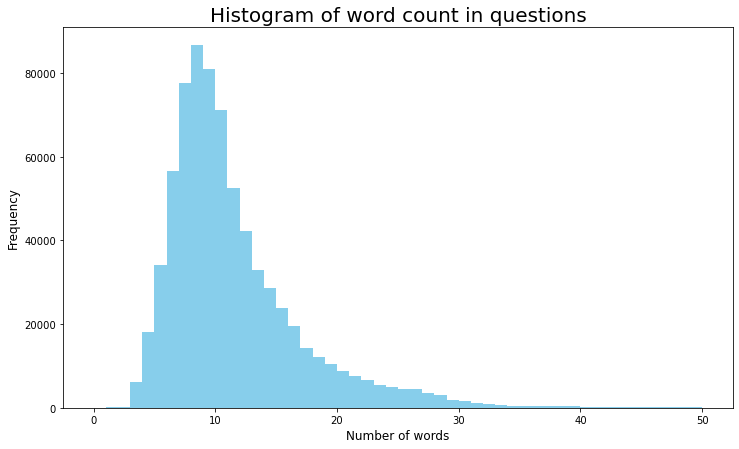

In [18]:
# Visualization by histogram

plt.figure(figsize=(12,7))

train_word_counts.plot(kind="hist", bins=50, range=[0,50], color="skyblue", label="words")
plt.title("Histogram of word count in questions", fontsize=20)
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

In [19]:
train_word_counts.describe()

count    727722.000000
mean         11.061709
std           5.879066
min           1.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         237.000000
dtype: float64

- It looks like most of the questions consist of around 10 words.
- However we can see that maximum count is at 237, which is pretty extreme considering the quantiles.
- We'll have to check again after preprocessing each questions

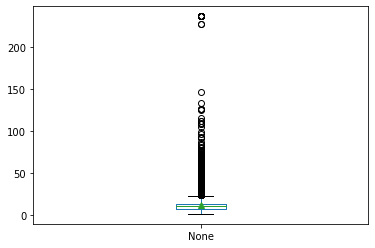

In [20]:
train_word_counts.plot(kind="box", showmeans=True)
plt.show()

- By boxplot, it is enough to conclude that our dataset has outliers that are broadly distributed.
- For further analysis, we would have to consider trimming outliers.

### Character Features

In [21]:
print("Questions with question marks: {} %".format(round(np.mean(train_set.apply(lambda x: "?" in x)), 3)))
print("Questions with first letter capital: {} %".format(round(np.mean(train_set.apply(lambda x: x[0].isupper())), 3)))
print("Questions with math tags: {} %".format(round(np.mean(train_set.apply(lambda x: "[math]" in x)), 3)))
print("Questions with periods: {} %".format(round(np.mean(train_set.apply(lambda x: "." in x)), 3)))

Questions with question marks: 0.999 %
Questions with first letter capital: 0.998 %
Questions with math tags: 0.001 %
Questions with periods: 0.063 %


- Most of the questions contain question mark and have first letter capitalized, which is straightforward.
- Since these characteristics show rate of more than 99%, it is sufficient to conclude that they are general features and it would be fine to ignore them in the future analysis.

# Data Cleansing

### Label Balancing

Undersampling duplicated questions

In [22]:
train_0 = train_data[train_data["is_duplicate"] == 0]
train_1 = train_data[train_data["is_duplicate"] == 1]

print(train_0.shape)
print(train_1.shape)

(229434, 3)
(134427, 3)


In [23]:
val_0 = val_data[val_data["is_duplicate"] == 0]
val_1 = val_data[val_data["is_duplicate"] == 1]

print(val_0.shape)
print(val_1.shape)

(25593, 3)
(14836, 3)


In [24]:
train_0 = train_0.sample(len(train_1)).reset_index(drop="index")
train_0.shape

(134427, 3)

In [25]:
train_data = pd.concat([train_0, train_1]).reset_index(drop="index")
train_data

,question1,question2,is_duplicate
0,What are some examples of 7 line stanza poems?,What are some examples of poems with 4 stanzas...,0
1,What are some effective techniques for overcom...,How do I beat the impostor syndrome out of my ...,0
2,How do you cook Spam in a microwave oven?,What happens if I cook a car battery in the mi...,0
3,How do I Avail the Bangalore Escorts Service b...,Which is the best escort service in Bangalore?,0
4,What are your favourite Marathi songs?,Which are the popular marathi songs?,0
...,...,...,...
268849,Will the next generation of parenting change o...,What kind of parents will the next generation ...,1
268850,What are some outfit ideas to wear to a frat p...,What are some outfit ideas wear to a frat them...,1
268851,How does a long distance relationship work?,How are long distance relationships maintained?,1
268852,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1


### Remove special characters

In [26]:
# A sample question to be used for illustrating preprocessing steps
sample = train_data.question1[0]
sample

'What are some examples of 7 line stanza poems?'

In [27]:
import re 

result = re.sub(r"[^a-zA-Z]", " ", sample)   # Remove everything except alphabets
result

'What are some examples of   line stanza poems '

### Convert letter case

In [28]:
result = result.lower().split()
result

['what', 'are', 'some', 'examples', 'of', 'line', 'stanza', 'poems']

### Remove stopwords

In [29]:
from nltk.corpus import stopwords

stopwords_set = set(stopwords.words("english"))
result = [word for word in result if word not in stopwords_set]
result = " ".join(result)
result

'examples line stanza poems'

### Lemmatization

Goal of lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

In [30]:
from nltk import word_tokenize

result = word_tokenize(result)    # Tokenize sentence into seperate words
result

['examples', 'line', 'stanza', 'poems']

In [31]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Lemmatize ( ADJ, ADJ_SAT, ADV, NOUN, VERB = "a", "s", "r", "n", "v" )
result = list(map(lambda x: lemmatizer.lemmatize(x, "a"), result))
result = list(map(lambda x: lemmatizer.lemmatize(x, "s"), result))
result = list(map(lambda x: lemmatizer.lemmatize(x, "r"), result))
result = list(map(lambda x: lemmatizer.lemmatize(x, "n"), result))
result = list(map(lambda x: lemmatizer.lemmatize(x, "v"), result))

result

['example', 'line', 'stanza', 'poem']

- Words have been lemmatized to inflectional forms.

### Abstraction

Abtract above preprocessing steps into a single function.

In [32]:
def lemmatize_words(tokens) -> list:
    """
    Parameters:
        tokens: 
            sentence splitted by words
    """

    # Lemmatize ( ADJ, ADJ_SAT, ADV, NOUN, VERB = "a", "s", "r", "n", "v" )
    lemmatizer = WordNetLemmatizer()

    tokens = list(map(lambda x: lemmatizer.lemmatize(x, "a"), tokens))
    tokens = list(map(lambda x: lemmatizer.lemmatize(x, "s"), tokens))
    tokens = list(map(lambda x: lemmatizer.lemmatize(x, "r"), tokens))
    tokens = list(map(lambda x: lemmatizer.lemmatize(x, "n"), tokens))
    tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))

    return tokens



def preprocessing(sentence, remove_stopwords = True):
    """
    Parameters:
        sentence:
            Raw Sentence
        remove_stopwords:
            option to use stopwords or not
    """

    # Remove special characters
    result = re.sub(r"[^a-zA-Z]", " ", str(sentence))   # Remove everything except alphabets

    # Convert to lower case
    result = result.lower().split()

    # Remove Stopwords
    global stopwords_set
    if remove_stopwords:
        result = [word for word in result if word not in stopwords_set]
        result = " ".join(result)
    else:
        result = " ".join(result)


    # 4. Lemmatization
    result = word_tokenize(result)    # Tokenize sentence into seperate words
    result = lemmatize_words(result)  # Apply predefined lemmatization function

    return result


In [33]:
# Apply preprocessing to train questions

question1_preprocessed = train_data["question1"].apply(preprocessing)
question2_preprocessed = train_data["question2"].apply(preprocessing)

question1_preprocessed = pd.Series(list(question1_preprocessed))
question2_preprocessed = pd.Series(list(question2_preprocessed))

In [34]:
question1_preprocessed[:3]  # Example of preprocessed questions

0                        [example, line, stanza, poem]
1    [effective, technique, overcome, impostor, syn...
2                        [cook, spam, microwave, oven]
dtype: object

In [35]:
# Apply preprocessing to validation questions

val_question1_preprocessed = val_data["question1"].apply(preprocessing)
val_question2_preprocessed = val_data["question2"].apply(preprocessing)

val_question1_preprocessed = pd.Series(list(val_question1_preprocessed))
val_question2_preprocessed = pd.Series(list(val_question2_preprocessed))

# Word2Vec Vectorization

In [36]:
# Combine two questions into a single array

questions = []

for i in range(len(question1_preprocessed)):
    questions.append(question1_preprocessed[i])

for i in range(len(question2_preprocessed)):
    questions.append(question2_preprocessed[i])

for i in range(len(val_question1_preprocessed)):
    questions.append(val_question1_preprocessed[i])

for i in range(len(val_question2_preprocessed)):
    questions.append(val_question2_preprocessed[i])

    
questions = pd.Series(questions)

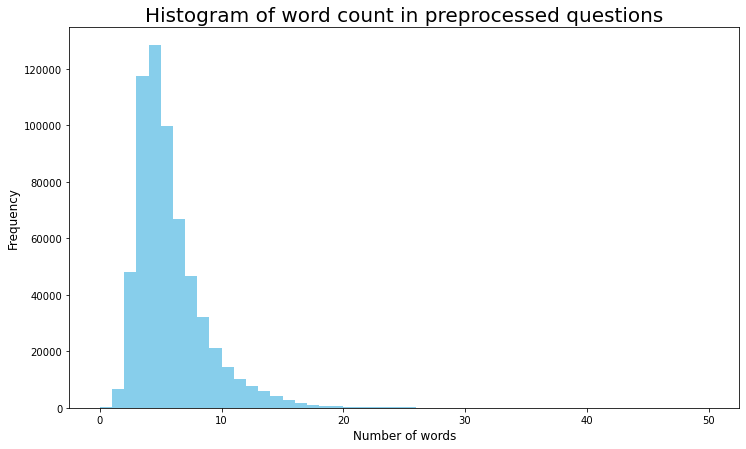

In [37]:
# Histogram of preprocessed word counts
plt.figure(figsize=(12,7))
questions.apply(len).plot(kind="hist", bins=50, range=[0,50], color="skyblue", label="words")
plt.title("Histogram of word count in preprocessed questions", fontsize=20)
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [38]:
questions.apply(len).describe()

count    618566.000000
mean          5.292868
std           2.914924
min           0.000000
25%           3.000000
50%           5.000000
75%           6.000000
max          97.000000
dtype: float64

- Most of the words have less than 10 words. We will use 10 as a padding size.

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions)

threshold = 2                            # word frequency threshold
total_cnt = len(tokenizer.word_index)    # number of total vocabularies
rare_cnt = 0                             # number of sparse vocabularies
total_freq = 0                           # count for total word frequency
rare_freq = 0                            # count for sparse word frequency  


for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value <= threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('Vocabulary Size: : {}'.format(total_cnt))
print('Number of sparse words that have less frequency than {} times: {}'.format(threshold, rare_cnt))
print("Rate of sparse words over total vocabulary set: {:.2f}%".format(rare_cnt / total_cnt * 100))
print("Rate of document frequency of sparse words: {:.2f}%".format(rare_freq / total_freq * 100))

Vocabulary Size: : 54037
Number of sparse words that have less frequency than 2 times: 29086
Rate of sparse words over total vocabulary set: 53.83%
Rate of document frequency of sparse words: 1.13%


- Words that appear less than 2 times account for 54% of total vocabularies, while their document frequency is only 1%.
- It would be reasonable to remove those rare words in further analysis.

### Import pretrained word2vec model

- word2vec vectors will be used as a weight matrix

In [40]:
# Import pretrained word2vec model

from gensim.models import KeyedVectors

word_embeddings_file_path = "/Users/dongwook/Desktop/GoogleNews-vectors-negative300.bin"   # Downloaded Google News word2vec model
model = KeyedVectors.load_word2vec_format(word_embeddings_file_path, binary=True)
print("Number of Tokens: {}".format(len(model.vocab)))

Number of Tokens: 3000000


### Tokenization & Padding

- Convert each question into unique integer values

In [41]:
from keras.preprocessing.sequence import pad_sequences

# Train questions
sequence1 = tokenizer.texts_to_sequences(question1_preprocessed)
sequence2 = tokenizer.texts_to_sequences(question2_preprocessed)

q1 = pad_sequences(sequence1, maxlen=10, padding="post")
q2 = pad_sequences(sequence2, maxlen=10, padding="post")

In [42]:
# Validation questions
val_sequence1 = tokenizer.texts_to_sequences(val_question1_preprocessed)
val_sequence2 = tokenizer.texts_to_sequences(val_question2_preprocessed)

val_q1 = pad_sequences(val_sequence1, maxlen=10, padding="post")
val_q2 = pad_sequences(val_sequence2, maxlen=10, padding="post")

In [43]:
print(q1.shape)
q1

(268854, 10)


array([[ 106,  504, 9346, ...,    0,    0,    0],
       [ 572, 1529,  418, ...,    0,    0,    0],
       [ 851, 4159, 2186, ...,    0,    0,    0],
       ...,
       [  69,  487,  181, ...,    0,    0,    0],
       [6525,   89, 2475, ...,    0,    0,    0],
       [ 235,   14,  437, ...,    0,    0,    0]], dtype=int32)

In [44]:
word_index = tokenizer.word_index
print("{} unique tokens".format(len(word_index)))

54037 unique tokens


### Embedding Matrix

In [45]:
embedding_matrix = np.zeros([len(word_index) + 1, 300])

for word, i in word_index.items():
    if word in model.vocab:
        embedding_matrix[i] = model.word_vec(word)
        
print("Number of null embeddings: {}".format(np.sum(np.sum(embedding_matrix, axis=1) == 0)))

Number of null embeddings: 23400


In [46]:
print(embedding_matrix.shape)
embedding_matrix

(54038, 300)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12695312,  0.02197266,  0.28710938, ..., -0.1015625 ,
        -0.09033203,  0.08837891],
       [ 0.03320312, -0.08984375, -0.29492188, ..., -0.12695312,
         0.16113281, -0.16015625],
       ...,
       [-0.12988281, -0.18359375, -0.01611328, ..., -0.07617188,
        -0.05419922,  0.28125   ],
       [-0.05419922, -0.02526855,  0.08398438, ..., -0.4296875 ,
         0.01025391,  0.04956055],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [47]:
train_label = train_data.is_duplicate  # train labels
val_label = val_data.is_duplicate      # validation labels

In [48]:
# Save preprocessed train data
np.save(open("/Users/dongwook/Desktop/q1.npy", "wb"), q1)
np.save(open("/Users/dongwook/Desktop/q2.npy", "wb"), q2)
np.save(open("/Users/dongwook/Desktop/label.npy", "wb"), train_label)
np.save(open("/Users/dongwook/Desktop/embedding.npy", "wb"), embedding_matrix)

# Modelling

We use Manhatten LSTM which was introduced in the article [Siamese Recurrent Architectures for Learning Sentence Similarity](https://www.researchgate.net/publication/307558687_Siamese_Recurrent_Architectures_for_Learning_Sentence_Similarity) by Aditya Thyagarajan.

In [52]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [53]:
class maLSTM(tf.keras.Model):

    def __init__(self, **kwargs):
        super(maLSTM, self).__init__(name=kwargs["model_name"])
        self.embedding = tf.keras.layers.Embedding(input_dim=kwargs["input_dimension"],
                                                   output_dim=kwargs["output_dimension"],
                                                   weights=[embedding_matrix],
                                                   trainable=False)
        self.lstm = tf.keras.layers.LSTM(kwargs["lstm_dimension"], 
                                         unit_forget_bias =True,
                                         kernel_initializer="he_normal",
                                         dropout=0.2,
                                         name="lstm_layer")
        self.manh_dist = tf.keras.layers.Lambda(function=(lambda x: tf.keras.backend.abs(x[0] - x[1])),
                                                name="manh_dist")
        self.prediction = tf.keras.layers.Dense(1, activation="sigmoid", name="similarity_layer")


    def call(self, x):
        x1, x2 = x
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)

        x1 = self.lstm(x1)
        x2 = self.lstm(x2)

        manh_dist = self.manh_dist((x1, x2))
        prediction = self.prediction(manh_dist)

        return prediction

In [54]:
BATCH_SIZE = 512
NUM_EPOCHS = 200
VALID_SPLIT = 0.1

kwargs = {
    "model_name": "maLSTM_similarity",
    "input_dimension": embedding_matrix.shape[0],
    "output_dimension": embedding_matrix.shape[1],
    "lstm_dimension": 50
}

model = maLSTM(**kwargs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")])

earlystop_callback = EarlyStopping(monitor="val_loss", patience=10)
checkpoint_path = "/Data/weights.h5"

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True
)

In [ ]:
# Train model
history = model.fit((q1, q2), train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                   validation_split=VALID_SPLIT, shuffle=True, callbacks=[earlystop_callback, cp_callback])

- To use GPU to accelerate training speed, I've used Colab. Assume the training was finished, imported trained weights will be used.

In [55]:
# Initialize model
history = model.fit((q1, q2), train_label, batch_size=BATCH_SIZE, epochs=1)

# Load trained weights
model.load_weights("/Users/dongwook/Desktop/weights.h5")

526/526 [==============================] - 29s 50ms/step - loss: 0.6441 - accuracy: 0.6003


In [56]:
# Evaluation for validation questions
model.evaluate((val_q1, val_q2), val_label)

1264/1264 [==============================] - 3s 2ms/step - loss: 0.5186 - accuracy: 0.7711


[0.5186185240745544, 0.7710554599761963]

- Trained model showed about 77% accuracy on validation questions.